## Create Virtual Environment To Run Your Code

It's good practice to create a virtual environment, so that you have a clean place to install packages in and run your code. This way, packages that you've installed outside of the environment won't mess with the installs in your virtual environment and vice versa. To create a virtual environment, you can run the following commands in your terminal:

**Create environment called 'ebm':** <br/>
%python3 -m venv ebm

**Activate environment:** <br/>
%source ebm/bin/activate

**Install packages:** <br/>
%pip install --upgrade jupyter matplotlib numpy pandas scipy scikit-learn interpret lightgbm hyperopt

**Add the environment as a kernel called 'ebm' you can select while in jupyter notebook:**<br/>
%pip install ipykernel
%python -m ipykernel install --user --name ebm --display-name ebm

Note: you only need to run all the commands above when you're first creating the environment. Once your environment is created, you can just run $source ebm/bin/activate when you want to activate the environment.

## Import Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from typing import Optional, Self
from interpret.glassbox import ExplainableBoostingClassifier as EBC 
from interpret import show

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier

from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope

In [4]:
# Read in data
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv"
total_df = pd.read_csv(url)
total_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## 2. EDA

In [5]:
# Basic info
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [7]:
# Check class imbalance - pretty balanced
total_df['species'].value_counts() / len(total_df)

species
Adelie       0.441860
Gentoo       0.360465
Chinstrap    0.197674
Name: count, dtype: float64

In [10]:
# See categories of categorical variables and percentages
total_df['island'].value_counts() / len(total_df)

island
Biscoe       0.488372
Dream        0.360465
Torgersen    0.151163
Name: count, dtype: float64

In [11]:
# See categories of categorical variables
total_df['sex'].value_counts() / len(total_df)

sex
MALE      0.488372
FEMALE    0.479651
Name: count, dtype: float64

In [8]:
# Summary stats
total_df.describe()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
count,342.000000,342.000000,342.000000,342.000000
mean,43.921930,17.151170,200.915205,4201.754386
std,5.459584,1.974793,14.061714,801.954536
min,32.100000,13.100000,172.000000,2700.000000
25%,39.225000,15.600000,190.000000,3550.000000
50%,44.450000,17.300000,197.000000,4050.000000
75%,48.500000,18.700000,213.000000,4750.000000
max,59.600000,21.500000,231.000000,6300.000000


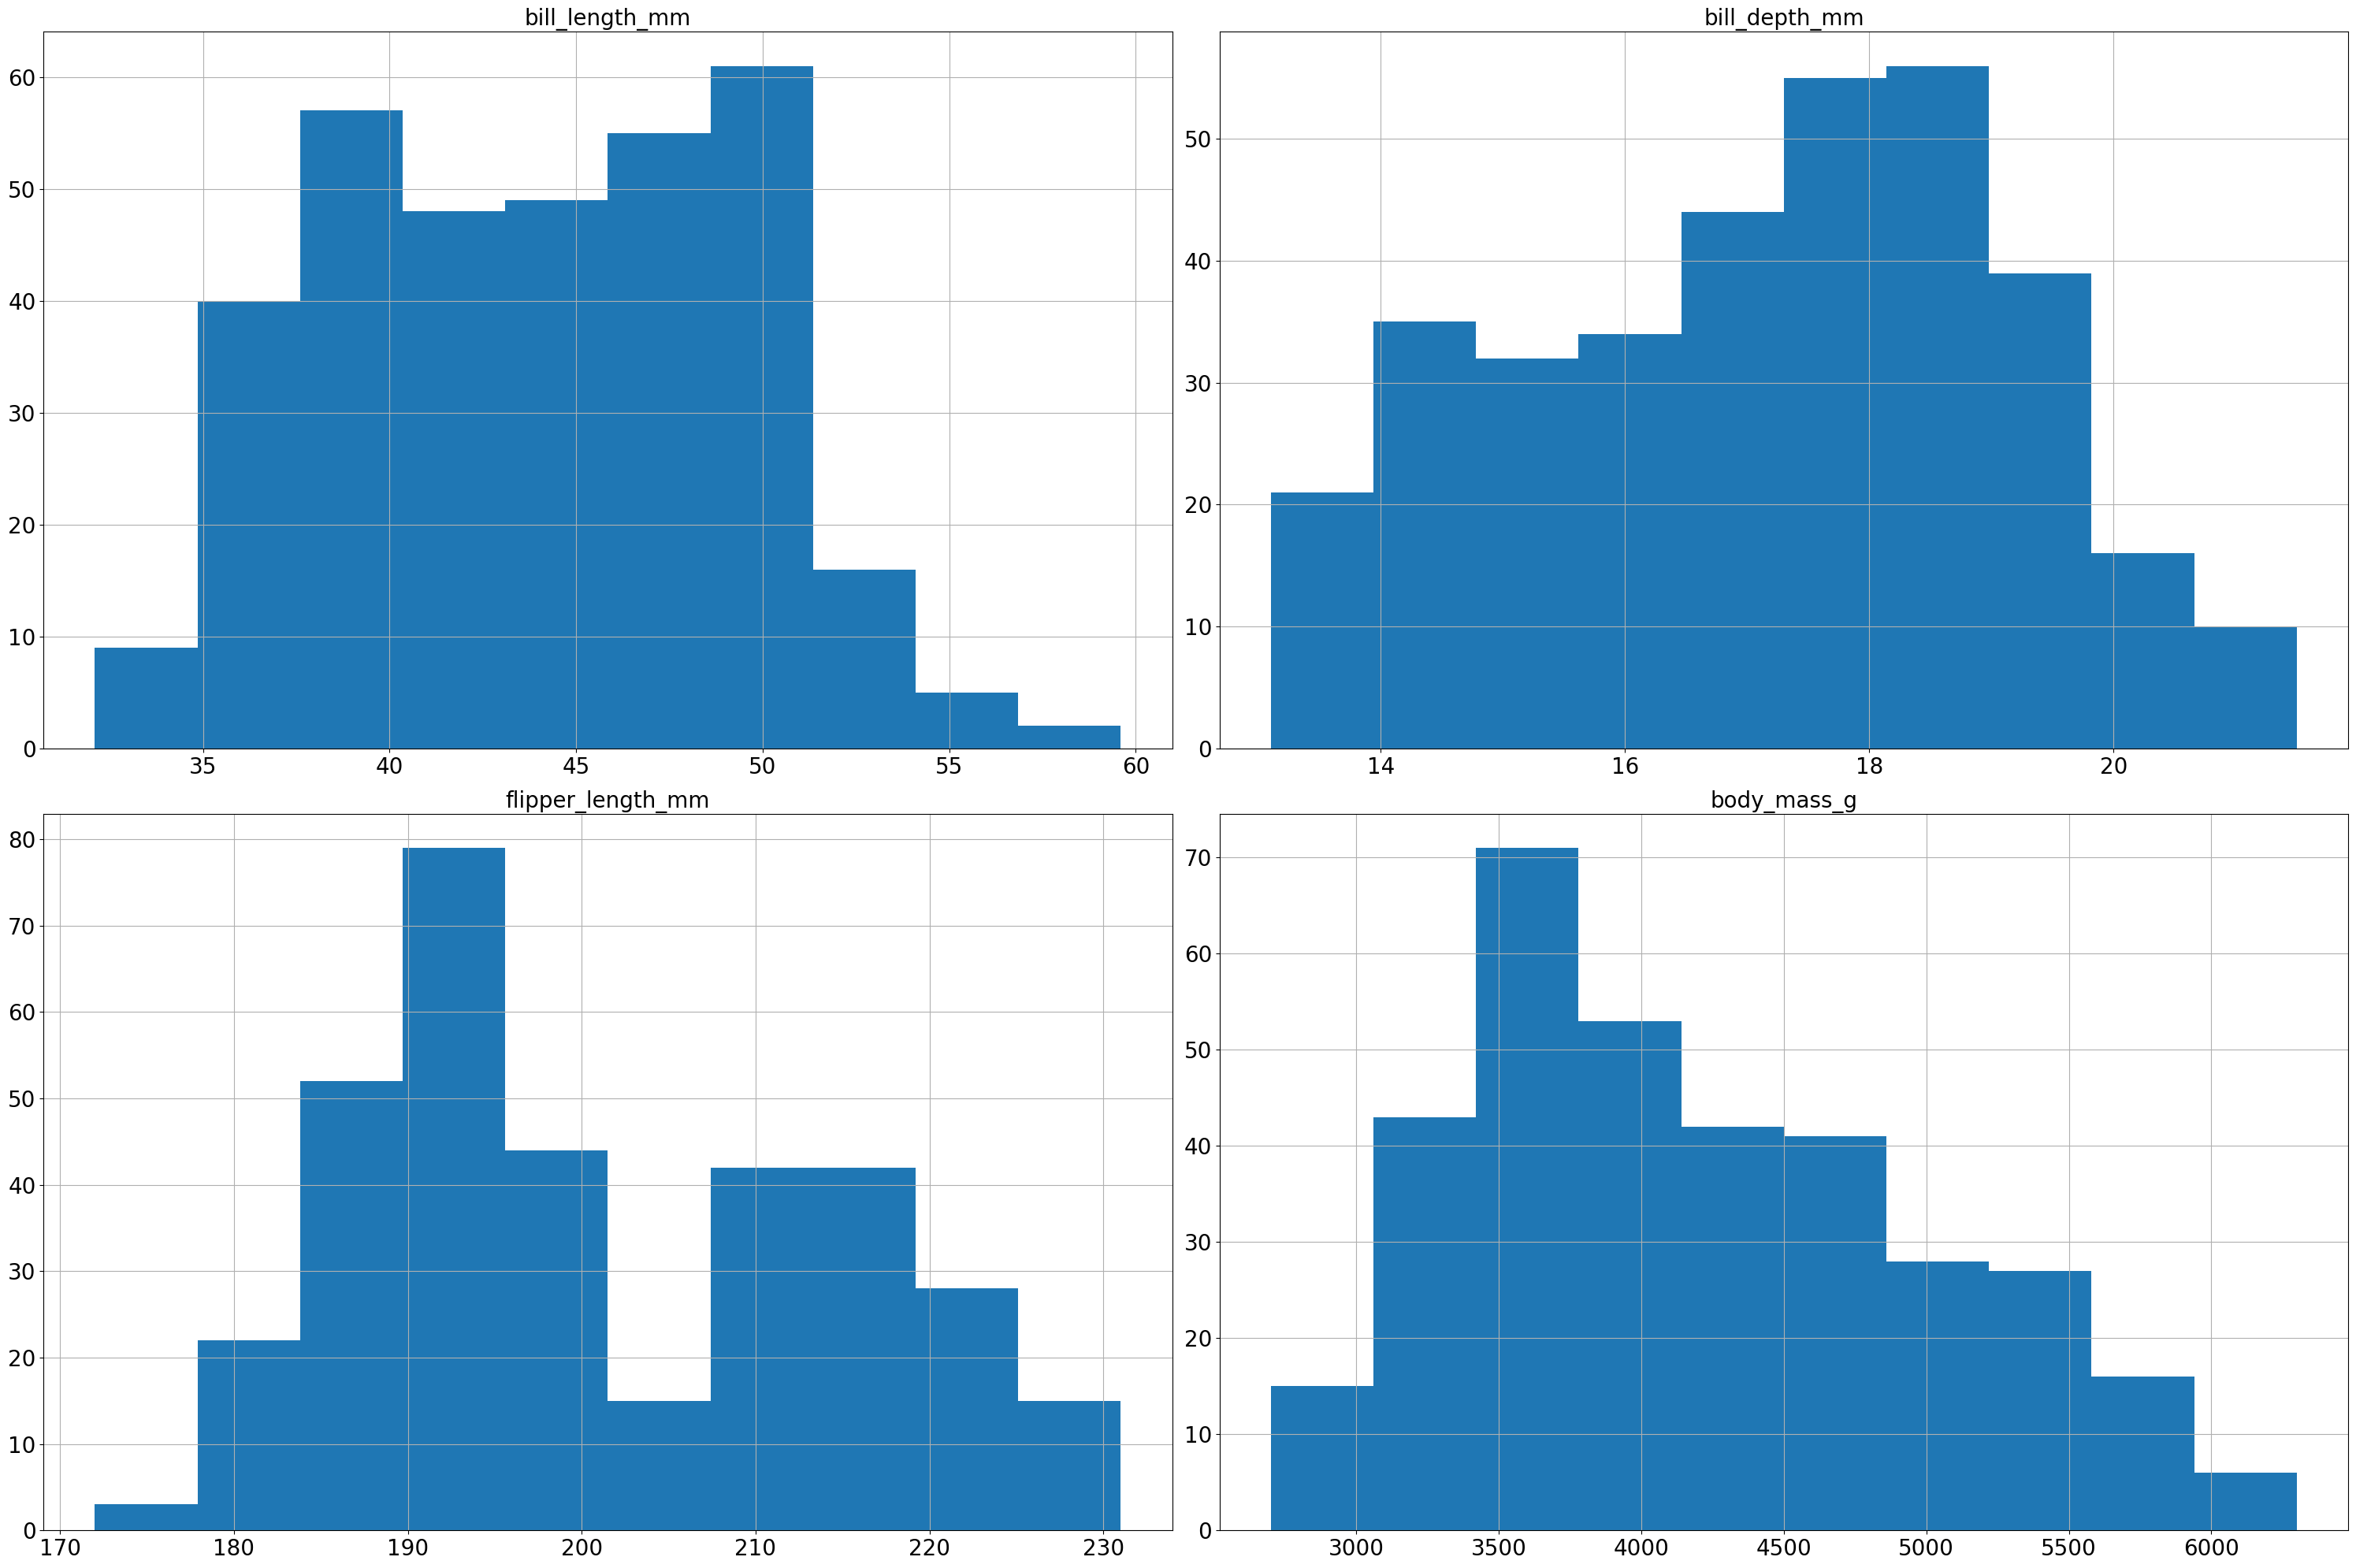

In [12]:
# Get distribution of each variable - flipper length bimodal, body mass skewed
params = {'axes.titlesize':'20'}
matplotlib.rcParams.update(params)
total_df.hist(bins=10, figsize=(30, 20), xlabelsize=20, ylabelsize=20)
plt.tight_layout()

## 3. Split Data & Pre-Processing

In [13]:
# Set variables
random_state = 42
test_size = 0.25

In [32]:
# Split into training and test datasets
target = ['species']
X = total_df.drop(target, axis=1).reset_index(drop=True)
y = total_df[target].reset_index(drop=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
17,Torgersen,42.5,20.7,197.0,4500.0,MALE
24,Biscoe,38.8,17.2,180.0,3800.0,MALE
238,Biscoe,46.2,14.5,209.0,4800.0,FEMALE
145,Dream,39.0,18.7,185.0,3650.0,MALE
209,Dream,49.3,19.9,203.0,4050.0,MALE


In [16]:
y_train.head()

,species
17,Adelie
24,Adelie
238,Gentoo
145,Adelie
209,Chinstrap


In [18]:
# Sanity check - correct shapes after split
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((258, 6), (258, 1), (86, 6), (86, 1))

In [33]:
# Separate numerical and categorical column lists
def get_num_cat_cols(df: pd.DataFrame) -> tuple[list, list]:
    """
    Given a dataframe, return a list of the numerical columns and a list of the categorical columns.
    
    Parameters
    ----------
        df: The pandas dataframe.

    Returns
    -------
        cat_cols: list of categorical columns
        num_cols: list of numerical columns
    """
    categorical_columns_selector = selector(dtype_include='object')
    cat_cols = categorical_columns_selector(df)
    num_cols = [col for col in df.columns if col not in cat_cols]
    return cat_cols, num_cols

cat_cols, num_cols =  get_num_cat_cols(X_train)
cat_cols, num_cols

(['island', 'sex'],
 ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])

### 3.1 Drop Low Variance Features

In [24]:
def drop_low_var_cols(df: pd.DataFrame, num_cols: Optional[list[str]]=num_cols, threshold: Optional[float]=0.1) -> pd.DataFrame:
    """
    Drop features with low variance (less than specified threshold). 
    
    Parameters
    ----------
        df: The pandas dataframe.
        num_cols: Optional list of numerical columns of dataframe, default=num_cols. 
        threshold: Optional threshold, default=0.1. 

    Returns
    -------
        df: The dataframe with low variance columns dropped.
    """
    variance = df[num_cols].var()
    low_var_cols = []
    
    for i in range(len(variance)):
    	if variance[i] < threshold:
    		low_var_cols.append(num_cols[i])

    print("Low variance columns dropped:", low_var_cols)
    df = df.drop(low_var_cols, axis=1)
    
    return df

In [34]:
threshold=0.1
X_train_drop = drop_low_var_cols(X_train, threshold=threshold)
X_train_drop.head()

Low variance columns dropped: []


,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
17,Torgersen,42.5,20.7,197.0,4500.0,MALE
24,Biscoe,38.8,17.2,180.0,3800.0,MALE
238,Biscoe,46.2,14.5,209.0,4800.0,FEMALE
145,Dream,39.0,18.7,185.0,3650.0,MALE
209,Dream,49.3,19.9,203.0,4050.0,MALE


### 3.2 Missing Values

Can drop, impute, or leave missing values if they're informative. We don't have that many missing values, but we don't have many samples, so I will fill with the median (more robust to outliers) for the numerical columns. 

In [35]:
# Deal with missing values - drop, impute, leave if informative
imputer = SimpleImputer(strategy="median").set_output(transform='pandas')
X_train_imp = imputer.fit_transform(X_train_drop[num_cols])
X_train_imp.isnull().any()

bill_length_mm       False
bill_depth_mm        False
flipper_length_mm    False
body_mass_g          False
dtype: bool

### 3.3 Drop Correlated Features

In [36]:
# Visualize correlated features
def get_relevant_pairs(df: pd.DataFrame, num_cols: Optional[list[str]]=num_cols) -> pd.DataFrame:
    """
    DESCRIPTION
    
    Parameters
    ----------
        df: The pandas dataframe.

    Returns
    -------
        cat_cols: list of categorical columns
        num_cols: list of numerical columns
    """
    corr_matrix = df[num_cols].corr().abs()
    relevant_pairs = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
                 .stack()
                 .sort_values(ascending=False))
    
    return relevant_pairs

relevant_pairs = get_relevant_pairs(X_train_imp)
relevant_pairs[:10] 

flipper_length_mm  body_mass_g          0.874255
bill_length_mm     flipper_length_mm    0.656701
                   body_mass_g          0.594006
bill_depth_mm      flipper_length_mm    0.582296
                   body_mass_g          0.485917
bill_length_mm     bill_depth_mm        0.219789
dtype: float64

Let's drop flipper length since it also has a less normal distribution.

In [52]:
class RemoveCollinear(BaseEstimator, TransformerMixin):
    """
    A class to remove collinear features.

    Attributes
    ----------
        threshold (float): correlation threshold. 
    
    Methods
    -------
        fit(X, y=None)
            Returns self. 

        transform(X, y=None)
            Returns dataframe with highly collinear columns dropped.
    """
    def __init__(self, threshold=0.8):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        # Calculate the correlation matrix
        corr_matrix = X.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []
        
        # Iterate through the correlation matri`x and compare correlations
        for i in iters:
            for j in range(i+1):
                item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
                col = item.columns
                row = item.index
                val = abs(item.values)
        
                if val >= self.threshold:
                    print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    col1 = col.values[0]
                    col2 = row.values[0]
                    drop_cols.append(col2)
        
        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        print(drops)
        X = X.drop(columns=drops)
        return X

    # # Allow setting output to pandas 
    # def get_feature_names_out(self, *args, **params):
    #     return self.columns_

In [53]:
collinear = RemoveCollinear(threshold=0.8)
test = collinear.fit_transform(X_train[num_cols])
test.head()

body_mass_g | flipper_length_mm | 0.87
{'flipper_length_mm'}


,bill_length_mm,bill_depth_mm,body_mass_g
17,42.5,20.7,4500.0
24,38.8,17.2,3800.0
238,46.2,14.5,4800.0
145,39.0,18.7,3650.0
209,49.3,19.9,4050.0


### 3.4 Outliers

In [39]:
cat_cols, num_cols =  get_num_cat_cols(X_train_imp)
num_cols

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

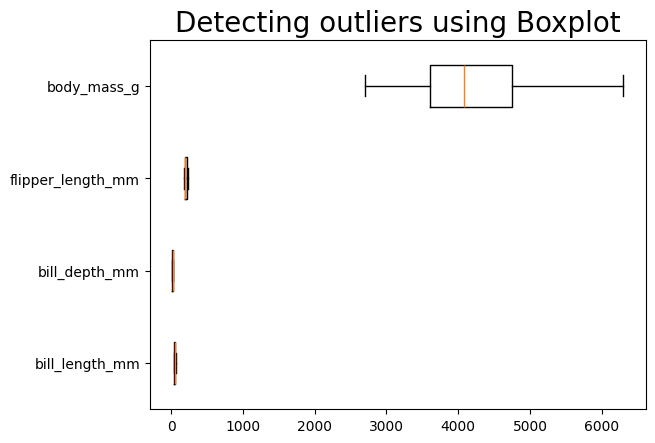

In [41]:
plt.boxplot(X_train_imp[num_cols], vert=False, labels=num_cols)
plt.title("Detecting outliers using Boxplot")
plt.show()

Don't have any major outliers using IQR method.

### 3.5 Feature Engineering

Interaction effects? Bill length x sex - bill length has a different effect on species outcome depending on sex

In [77]:
# Add engineered features
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    A class to add engineered features.

    Attributes
    ----------
    
    Methods
    -------
        fit(X, y=None)
            Returns self. 

        transform(X, y=None)
            Returns dataframe with engineered features
    """
    def __init__(self): # no *args or **kargs
        pass
    
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X['bill_length_sex'] = X['bill_length_mm'] * X['sex'] # One hot encode sex before so numerical values 
    
        return X

In [ ]:
# feature_adder = FeatureEngineer()
# feature_adder.transform(X_train_wins).head()

### 3.6 Normalize

In [ ]:
# Normalize or standardize
# Standardization better for normally dist variables + more robust to outliers

### 3.7 Categorical

In [42]:
# Let's leave the missing values for sex and fill with 'Unknown'- some species could be harder to identify gender by eye
# Since we don't have many columns or high cardinality, let's one hot encode the variables

### 3.8 Pipeline

In [49]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """
    A class to select numerical vs. categorical columns.

    Attributes
    ----------
        
    
    Methods
    -------
        fit(X, y=None)
            Returns self. 

        transform(X, y=None)
            Returns dataframe of numerical or categorical columns.
    """
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].reset_index(drop=True)

In [81]:
cat_cols, num_cols =  get_num_cat_cols(X_train)
cat_cols, num_cols

(['island', 'sex'],
 ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g'])

In [82]:
from sklearn import set_config
set_config(transform_output='pandas')

num_pipeline = Pipeline([
        ('num_selector', DataFrameSelector(num_cols)),
        ('imputer', SimpleImputer(strategy="median")),
        ('drop_collinear', RemoveCollinear(threshold=0.8)),
        # ('feat_engineer', FeatureEngineer()),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('cat_selector', DataFrameSelector(cat_cols)),
        ('imputer', SimpleImputer(strategy="constant", fill_value='Unknown'))
#         ,('encoder', OneHotEncoder()) # EBM better without encoding
]  
)

from sklearn.pipeline import FeatureUnion 
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline)
    ])

In [83]:
X_train.shape

(258, 6)

In [84]:
X_train_prep = full_pipeline.fit_transform(X_train).reset_index(drop=True)
X_train_prep.shape

body_mass_g | flipper_length_mm | 0.87
{'flipper_length_mm'}


(258, 5)

In [57]:
X_train_prep.head()

,bill_length_mm,bill_depth_mm,body_mass_g,island,sex
0,-0.258692,1.802177,0.373857,Torgersen,MALE
1,-0.936004,0.051192,-0.507586,Biscoe,MALE
2,0.418619,-1.299569,0.751618,Biscoe,FEMALE
3,-0.899392,0.801614,-0.696467,Dream,MALE
4,0.986096,1.401952,-0.192785,Dream,MALE


In [58]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258 entries, 0 to 257
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bill_length_mm  258 non-null    float64
 1   bill_depth_mm   258 non-null    float64
 2   body_mass_g     258 non-null    float64
 3   island          258 non-null    object 
 4   sex             258 non-null    object 
dtypes: float64(3), object(2)
memory usage: 10.2+ KB


In [59]:
X_train_prep['sex'].value_counts()

sex
MALE       126
FEMALE     124
Unknown      8
Name: count, dtype: int64

## 4. Initial Model - Explainable Boosting Classifier

In [61]:
# Default EBC
ebm = EBC()
ebm.fit(X_train_prep, y_train)

ExplainableBoostingClassifier()

In [62]:
X_test_prep = full_pipeline.transform(X_test)
y_pred = ebm.predict_proba(X_test_prep)
log_loss(y_test, y_pred)

body_mass_g | flipper_length_mm | 0.86
{'flipper_length_mm'}


0.0088057361797229

## 5. Hyperparameter Tuning - Hyperopt

In [65]:
n_jobs = -2
random_state = 44
cv = 3

In [66]:
# Objective function
# Neg_log_loss returns negative values
# Hyperopt minimizes 
def hyperparameter_tuning(params):
 clf = EBC(random_state=random_state, n_jobs=n_jobs, **params)
 neg_log_loss = cross_val_score(clf, X_train_prep, y_train, scoring="neg_log_loss", cv=cv, error_score="raise", n_jobs=n_jobs).mean()
 return {'loss': neg_log_loss, "status": STATUS_OK}

# Hyperparameters we want to tune
ob_choices = [10, 20, 30]
ib_choices = [10, 20, 30]
mb_choices = [32, 64, 128, 500, 1000]
ml_choices = [2, 3, 4, 5]


space = {
 'outer_bags': hp.choice("outer_bags", ob_choices),
 'inner_bags': hp.choice("inner_bags", ib_choices),
 'max_bins': hp.choice("max_bins", mb_choices),
 'max_leaves': hp.choice("max_leaves", ml_choices)
}

In [67]:
# Run tuning trials
trials = Trials()

best = fmin(
 fn=hyperparameter_tuning,
 space=space,
 algo=tpe.suggest,
 max_evals=5,
 trials=trials
)

  0%|                                                     | 0/5 [00:00<?, ?trial/s, best loss=?]

/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


 20%|████▊                   | 1/5 [00:11<00:45, 11.43s/trial, best loss: -0.031752471013125484]

/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meg

 40%|██████████               | 2/5 [00:44<01:12, 24.25s/trial, best loss: -0.03609749255307405]

/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meg

 60%|███████████████          | 3/5 [00:59<00:39, 19.87s/trial, best loss: -0.03653184347609085]

/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meg

 80%|███████████████████▏    | 4/5 [01:06<00:15, 15.00s/trial, best loss: -0.036880710692527456]

/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(
/Users/meg

100%|████████████████████████| 5/5 [01:18<00:00, 15.61s/trial, best loss: -0.036880710692527456]


/Users/meganfang/Desktop/DS/ebm_hyperopt/ebm/lib/python3.11/site-packages/interpret/glassbox/_ebm/_ebm.py:964: UserWarning: Detected multiclass problem. Forcing interactions to 0. Multiclass interactions only have local explanations. They are not currently displayed in the global explanation visualizations. Set interactions=0 to disable this warning. If you still want multiclass interactions, this API accepts a list, and the measure_interactions function can be used to detect them.
  warn(


In [68]:
# Get best results
print(f"Best: {best}")
print(trials.results)

Best: {'inner_bags': 1, 'max_bins': 0, 'max_leaves': 1, 'outer_bags': 0}
[{'loss': -0.031752471013125484, 'status': 'ok'}, {'loss': -0.03609749255307405, 'status': 'ok'}, {'loss': -0.03653184347609085, 'status': 'ok'}, {'loss': -0.036880710692527456, 'status': 'ok'}, {'loss': -0.03597995454323675, 'status': 'ok'}]


In [69]:
ib_choices[best['inner_bags']], ob_choices[best['outer_bags']], mb_choices[best['max_bins']], ml_choices[best['max_leaves']]

(20, 10, 32, 3)

In [70]:
# Refit with best hyperparams
ebm_best = EBC(inner_bags=ib_choices[best['inner_bags']], outer_bags=ob_choices[best['outer_bags']]
          , max_bins=mb_choices[best['max_bins']], max_leaves=ml_choices[best['max_leaves']])
ebm_best.fit(X_train_prep, y_train)

ExplainableBoostingClassifier(inner_bags=20, max_bins=32, outer_bags=10)

In [71]:
y_pred = ebm_best.predict_proba(X_test_prep)
log_loss(y_test, y_pred)

0.005273548634391651

## 6. Explain feature importances and term contributions

In [75]:
# Global model summary
show(ebm_best.explain_global())

<!-- http://127.0.0.1:7001/4954518992/ -->

In [76]:
# local model summary
show(ebm_best.explain_local(X_test_prep[:5], y_test[:5]), 0)

<!-- http://127.0.0.1:7001/4973221712/ -->